In [1]:
import argparse
import glob
import os
import pathlib
import logging

from PIL import Image

import cv2
import numpy as np
import openslide
import torch
import torch.nn as nn

import torchvision
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms

from skimage.color import rgb2gray
import matplotlib.pyplot as plt
from tifffile import memmap

import staintools

import pickle

import warnings
warnings.filterwarnings('ignore')

def load_model(pretrained):
    model = models.resnet18(pretrained=pretrained)
    model.fc = nn.Linear(in_features=512, out_features=9, bias=True)
    return model


def isBG(Img, BG_Thres, BG_Percent):
    Gray_Img = np.uint8(rgb2gray(Img) * 255)
    White_Percent = np.mean((Gray_Img > BG_Thres))
    Black_Percent = np.mean((Gray_Img < 255 - BG_Thres))

    if Black_Percent > BG_Percent or White_Percent > BG_Percent or Black_Percent + White_Percent > BG_Percent:
        return True
    else:
        return False
    
def PercentBackground(image, threshold):
    gray_scale = rgb2gray(image)
    binary = np.mean(gray_scale > threshold)
    
    return binary 

def get_region(grid_x, image_w, grid_w, margin_w):
    '''
    Return the base and offset pair to read from the image.
    :param grid_x: grid index on the image
    :param image_w: image width (or height)
    :param grid_w: grid width (or height)
    :param margin: margin width (or height)

    :return: the base index and the width on the image to read
    '''
    image_x = grid_x * grid_w

    image_l = min(image_x, image_w - grid_w)
    image_r = image_l + grid_w - 1

    read_l = max(0, image_l - margin_w)
    read_r = min(image_r + margin, image_w - 1)
    #    read_l = min(image_x - margin_w, image_w - (grid_w + margin_w))
    #    read_r = min(read_l + grid_w + (margin_w << 1), image_w) - 1
    #    image_l = max(0,read_l + margin_w)
    #    image_r = min(image_l + grid_w , image_w) - 1
    return read_l, image_l, image_r, read_r


def resize_region(im_l, im_r, scale_factor):
    sl = im_l // scale_factor
    sw = (im_r - im_l + 1) // scale_factor
    sr = sl + sw - 1
    return sl, sr




# In[4]:


patch_size = 2048

run_info = 'test_{}'.format(patch_size)

if not os.path.exists('checkpoints/{}'.format(run_info)):
    os.mkdir('checkpoints/{}'.format(run_info))

log = logging.getLogger('staining_log')
log.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
fileHandler = logging.FileHandler('checkpoints/{}/log.txt'.format(run_info))
streamHandler = logging.StreamHandler()
fileHandler.setFormatter(formatter)
streamHandler.setFormatter(formatter)
#
log.addHandler(fileHandler)
log.addHandler(streamHandler)












all_patient_name = [i.split('/')[-1].split('.')[0] for i in sorted(glob.glob('Dict{}/Page-1/*.pickle'.format(patch_size)))] +                    [i.split('/')[-1].split('.')[0] for i in sorted(glob.glob('Dict{}/Page-2/*.pickle'.format(patch_size)))] +                     [i.split('/')[-1].split('.')[0] for i in sorted(glob.glob('Dict{}/Page-3/*.pickle'.format(patch_size)))] +                     [i.split('/')[-1].split('.')[0] for i in sorted(glob.glob('Dict{}/Page-4/*.pickle'.format(patch_size)))] +                     [i.split('/')[-1].split('.')[0] for i in sorted(glob.glob('Dict{}/Page-5/*.pickle'.format(patch_size)))] +                     [i.split('/')[-1].split('.')[0] for i in sorted(glob.glob('Dict{}/Page-6/*.pickle'.format(patch_size)))] +                     [i.split('/')[-1].split('.')[0] for i in sorted(glob.glob('Dict{}/Page-7/*.pickle'.format(patch_size)))] +                     [i.split('/')[-1].split('.')[0] for i in sorted(glob.glob('Dict{}/Page-8/*.pickle'.format(patch_size)))] +                     [i.split('/')[-1].split('.')[0] for i in sorted(glob.glob('Dict{}/Page-9/*.pickle'.format(patch_size)))] +                     [i.split('/')[-1].split('.')[0] for i in sorted(glob.glob('Dict{}/Page-10/*.pickle'.format(patch_size)))]



dict_path = [i for i in sorted(glob.glob('Dict{}/Page-1/*.pickle'.format(patch_size)))] +             [i for i in sorted(glob.glob('Dict{}/Page-2/*.pickle'.format(patch_size)))] +             [i for i in sorted(glob.glob('Dict{}/Page-3/*.pickle'.format(patch_size)))] +             [i for i in sorted(glob.glob('Dict{}/Page-4/*.pickle'.format(patch_size)))] +             [i for i in sorted(glob.glob('Dict{}/Page-5/*.pickle'.format(patch_size)))] +             [i for i in sorted(glob.glob('Dict{}/Page-6/*.pickle'.format(patch_size)))] +             [i for i in sorted(glob.glob('Dict{}/Page-7/*.pickle'.format(patch_size)))] +             [i for i in sorted(glob.glob('Dict{}/Page-8/*.pickle'.format(patch_size)))] +             [i for i in sorted(glob.glob('Dict{}/Page-9/*.pickle'.format(patch_size)))] +             [i for i in sorted(glob.glob('Dict{}/Page-10/*.pickle'.format(patch_size)))]


    
    
######### Shuffle ########
all_patient_name = np.array(all_patient_name)
np.random.seed(777)
np.random.shuffle(all_patient_name)
all_patient_name = all_patient_name.tolist()
######### Shuffle ########


    
len_ = len(all_patient_name)
idx = int(len_*0.8)
    
train_patient = all_patient_name[:idx]
val_patient = all_patient_name[idx:]





all_svs_path = glob.glob('../../../../Projects/Pathology/datasets/HE_IHC/Stomach/Page*/*.svs')


val_idx = np.isin(np.array([i.split('/')[-1].split('.')[0] for i in all_svs_path]), np.array(val_patient))
val_svs_path = np.array(all_svs_path)[val_idx].tolist()

val_svs_path[:5]

['../../../../Projects/Pathology/datasets/HE_IHC/Stomach/Page-8/S15-11329-3R-high.svs',
 '../../../../Projects/Pathology/datasets/HE_IHC/Stomach/Page-8/S15-11058-6W-low.svs',
 '../../../../Projects/Pathology/datasets/HE_IHC/Stomach/Page-8/S15-11058-6V-low.svs',
 '../../../../Projects/Pathology/datasets/HE_IHC/Stomach/Page-8/S15-9060-3O-low.svs',
 '../../../../Projects/Pathology/datasets/HE_IHC/Stomach/Page-8/S15-7673-3Q-int.svs']

In [191]:
output_file_path = 'result_npy/{}'.format(patch_size)
if not os.path.exists(output_file_path):
    os.mkdir(output_file_path) 

    
temp = [i.split('/')[-1].split('.')[0] for i in val_svs_path]
    
for i in range(len(val_svs_path)):
    
    log.info("file_name : {}".format(temp[i]))
    log.info('path : {}'.format(val_svs_path[i]))
    
    HE_SLIDE = openslide.open_slide(val_svs_path[i])
    slide_width, slide_height = HE_SLIDE.dimensions
    
    
    local_size = patch_size
    
    
    num_w = slide_width // local_size
    num_h = slide_height // local_size
    
    A = np.ones((num_w, num_h))  #
    iter_list = [[i[0][0],
                    i[0][1]
                    ] for i in np.ndenumerate(A)]  #
    len_itr = len(iter_list)
    tsp_map = np.zeros((num_h, num_w))
        
        
    down_scale = 4
    original_npy = np.zeros(shape=(int(slide_height/down_scale) , int(slide_width/down_scale)))
    log.info('Width : {} Height : {}'.format(int(slide_width/down_scale), int(slide_height/down_scale)))
    #down_npy = np.zeros(shape=(num_h, num_w))
            
    for idx, (x, y) in enumerate(iter_list):
        

         
        if idx % 100 == 0:
            log.info('Done {}/{}'.format(idx, len(iter_list)))
            
    result_path_ = '{}/{}_total1.npy'.format(output_file_path, temp[i])
    np.save(result_path_, original_npy)
    
    break

2021-08-17 12:47:18,483 - INFO - file_name : S15-15827-3P-low
2021-08-17 12:47:18,483 - INFO - file_name : S15-15827-3P-low
2021-08-17 12:47:18,483 - INFO - file_name : S15-15827-3P-low
INFO:staining_log:file_name : S15-15827-3P-low
2021-08-17 12:47:18,487 - INFO - path : ../../../../Projects/Pathology/datasets/HE_IHC/Stomach/Page-9/S15-15827-3P-low.svs
2021-08-17 12:47:18,487 - INFO - path : ../../../../Projects/Pathology/datasets/HE_IHC/Stomach/Page-9/S15-15827-3P-low.svs
2021-08-17 12:47:18,487 - INFO - path : ../../../../Projects/Pathology/datasets/HE_IHC/Stomach/Page-9/S15-15827-3P-low.svs
INFO:staining_log:path : ../../../../Projects/Pathology/datasets/HE_IHC/Stomach/Page-9/S15-15827-3P-low.svs
2021-08-17 12:47:18,499 - INFO - Width : 29382 Height : 16977
2021-08-17 12:47:18,499 - INFO - Width : 29382 Height : 16977
2021-08-17 12:47:18,499 - INFO - Width : 29382 Height : 16977
INFO:staining_log:Width : 29382 Height : 16977
2021-08-17 12:47:18,502 - INFO - Done 0/1881
2021-08-17 1

# Result Visualization

In [2]:
path_2048 = glob.glob('result_npy/2048/*')
path_3072 = glob.glob('result_npy/3072/*')

patient_name = [i.split('/')[-1].split('.')[0] for i in path_2048]




binary_path = glob.glob('result_npy/binary/*/*')
binary_idx = np.isin(np.array([i.split('/')[-1].split('.')[0] for i in binary_path]), np.array(patient_name))
binary_path_real = np.array(binary_path)[binary_idx].tolist()


image_path = glob.glob('result_npy/image/*/*')
image_idx = np.isin(np.array([i.split('/')[-1].split('.')[0] for i in image_path]), np.array(patient_name))
image_path_real = np.array(image_path)[image_idx].tolist()

In [156]:
cutoff = 0.95

a = temp > cutoff
a = np.argmax(a, axis=2)

Patient Name : S15-925-3Z-low


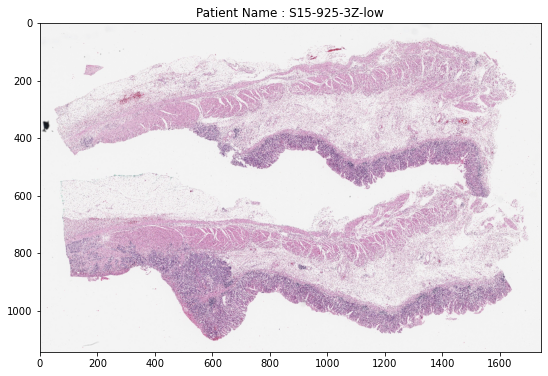

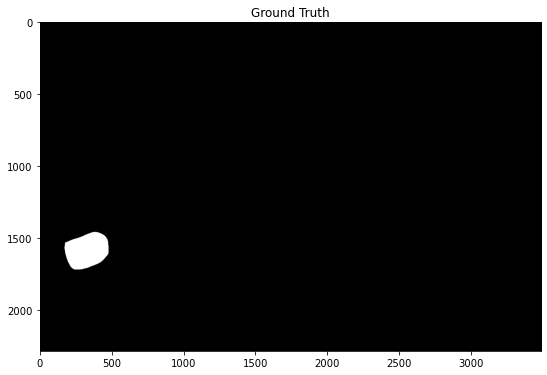

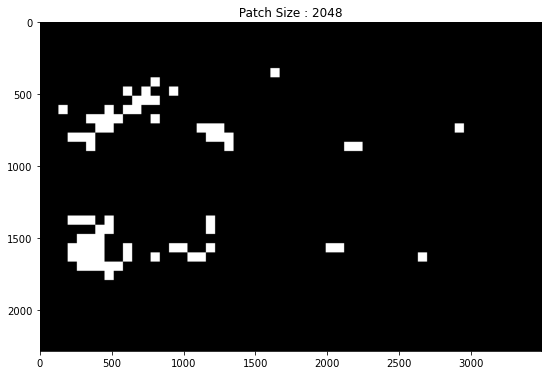

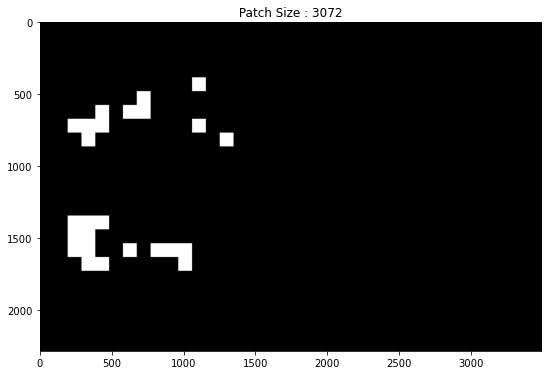

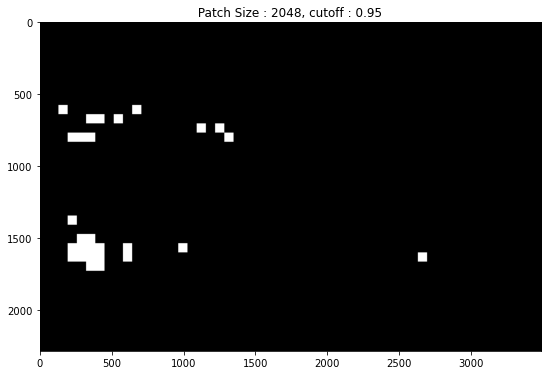

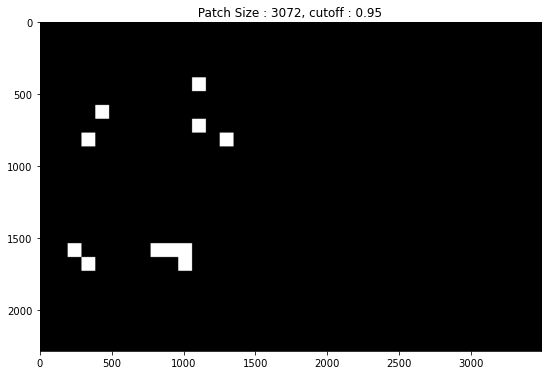



Patient Name : S14-06865-3V-HIGH


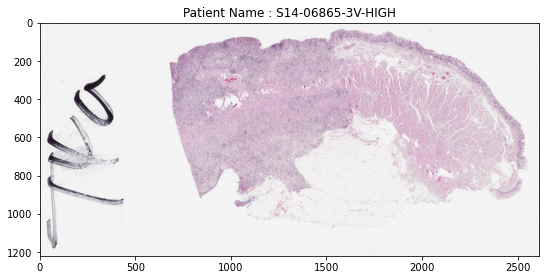

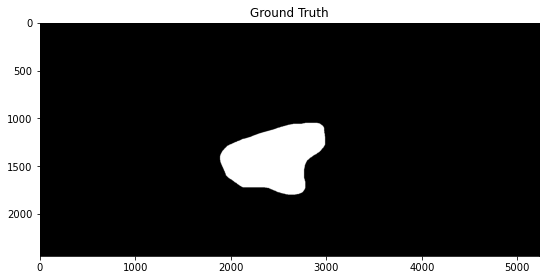

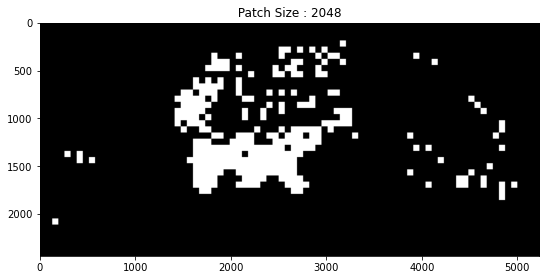

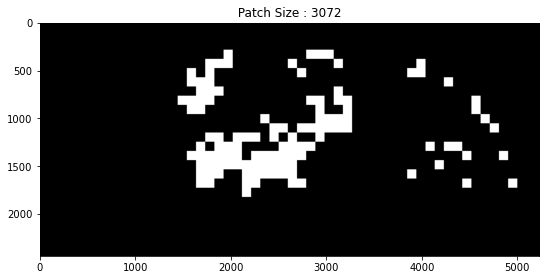

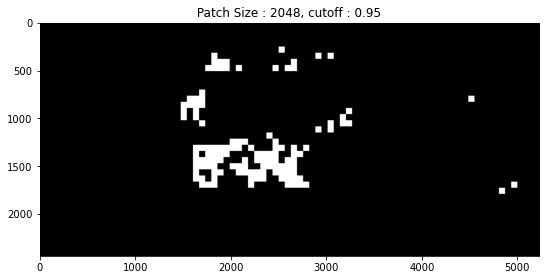

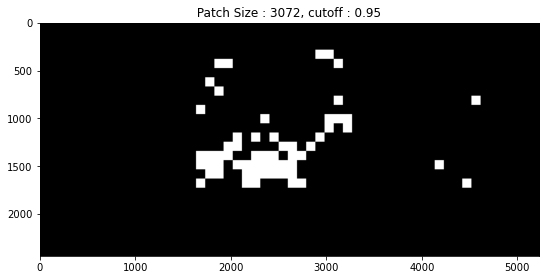



Patient Name : S14-10254-3S-HIGH


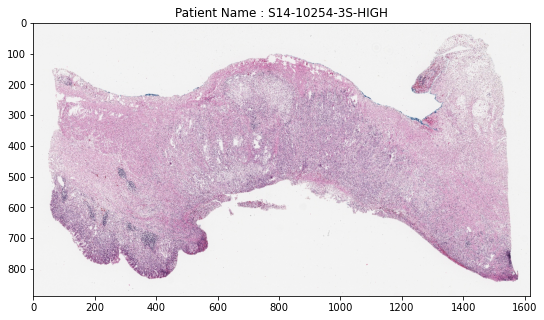

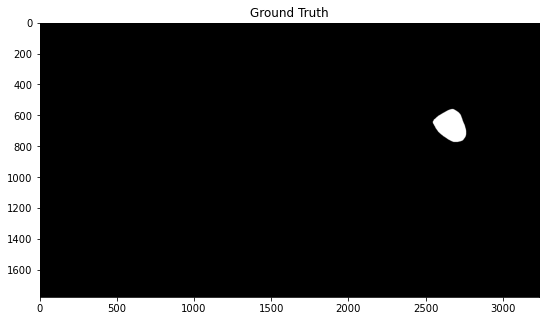

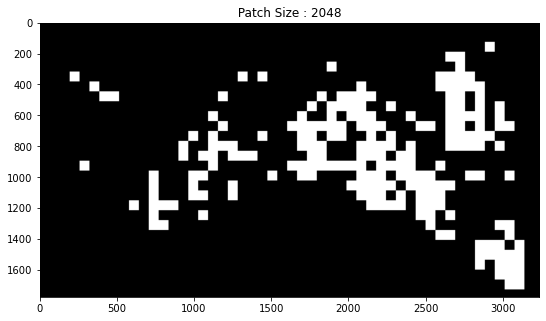

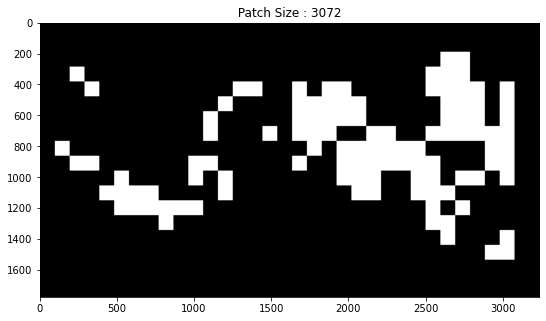

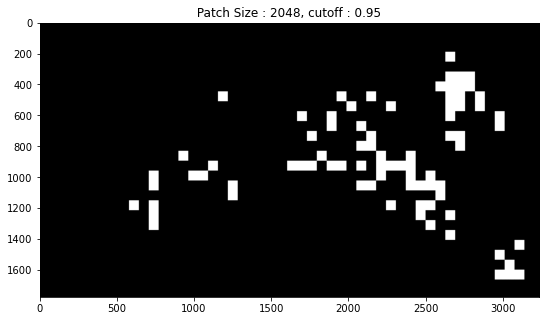

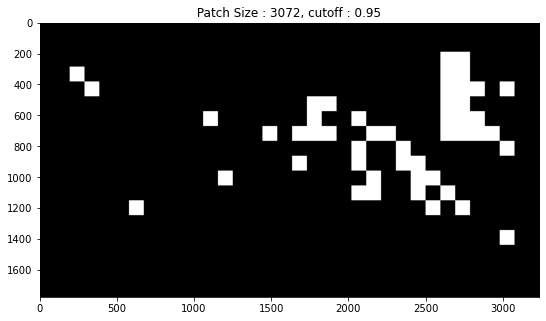



Patient Name : S15-17795-3P-high


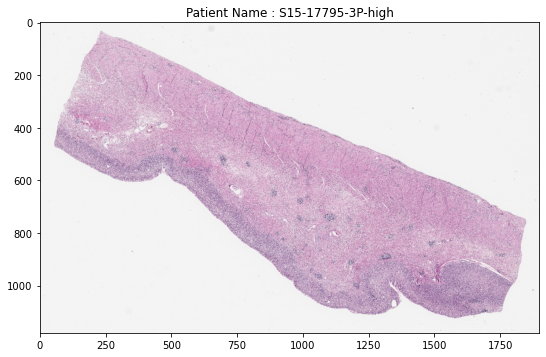

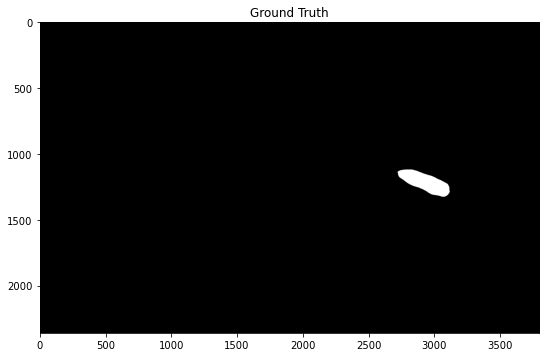

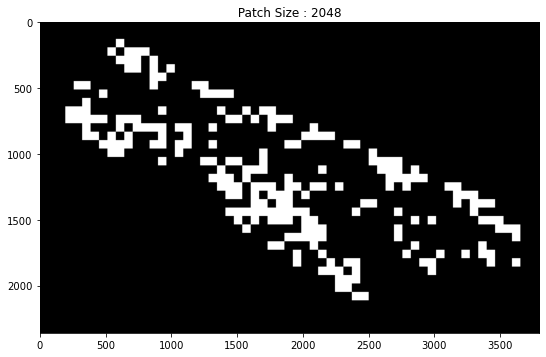

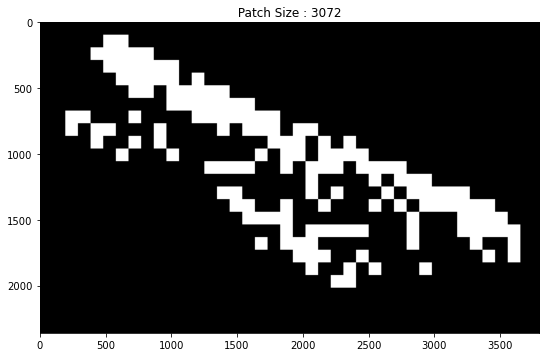

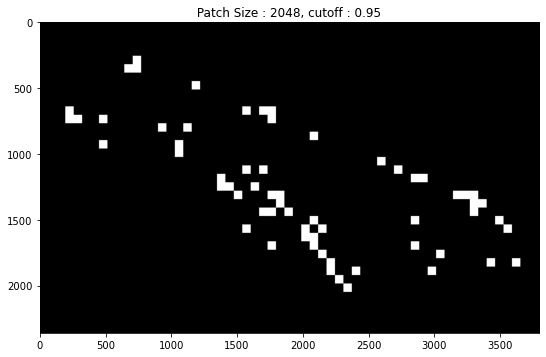

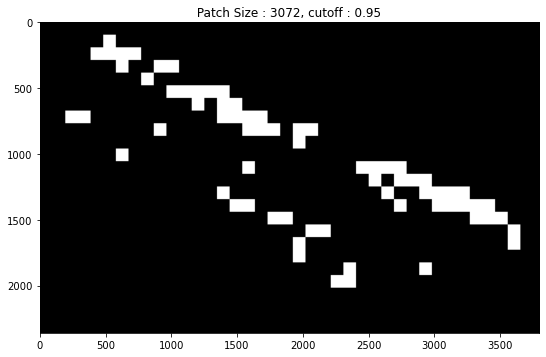



Patient Name : S14-31341-3U-int


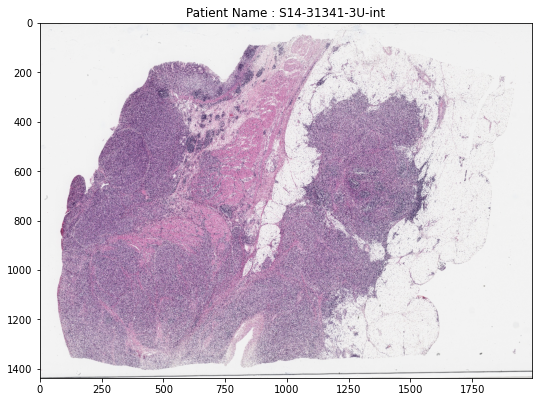

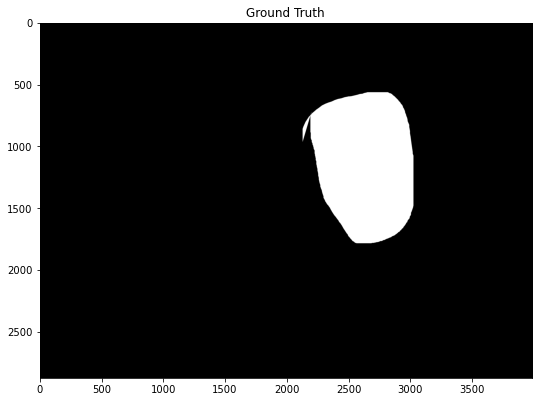

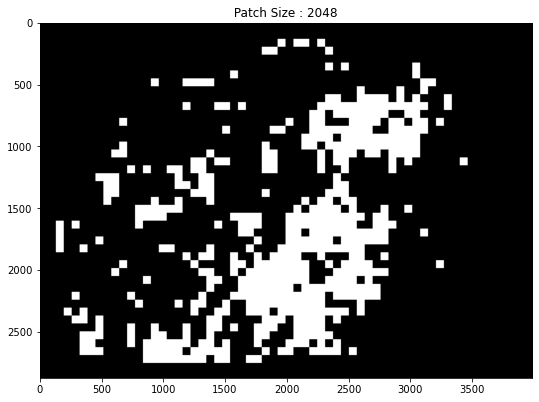

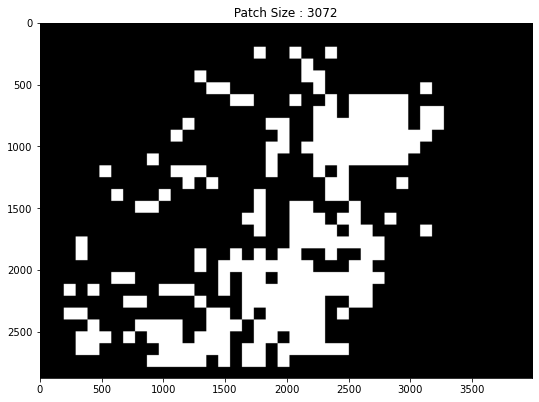

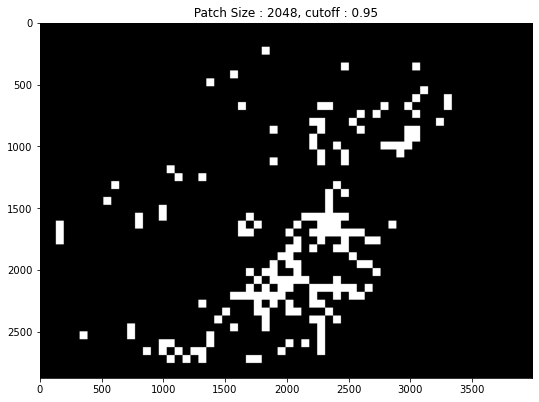

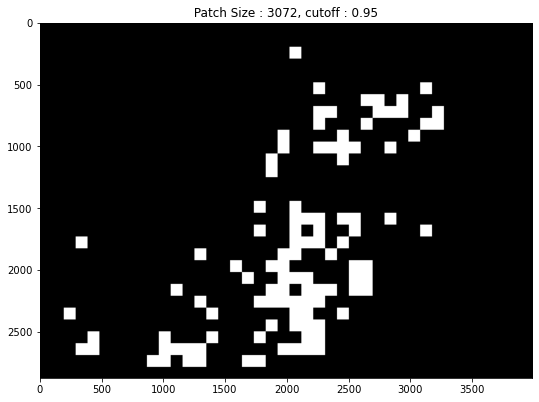



Patient Name : S14-15292-3P-INT


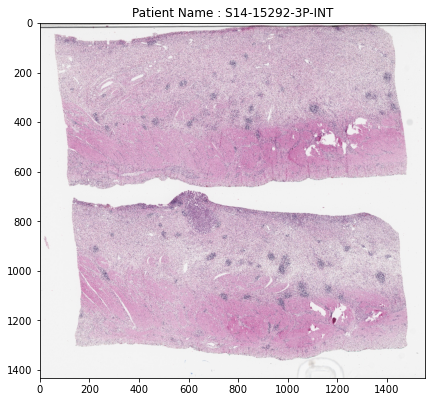

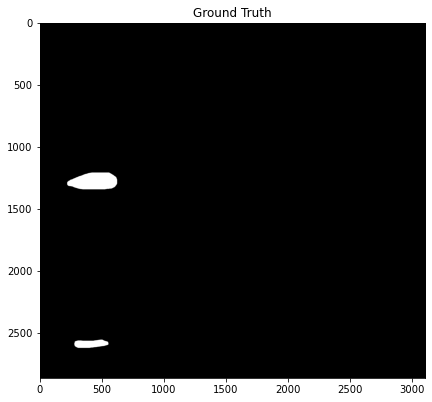

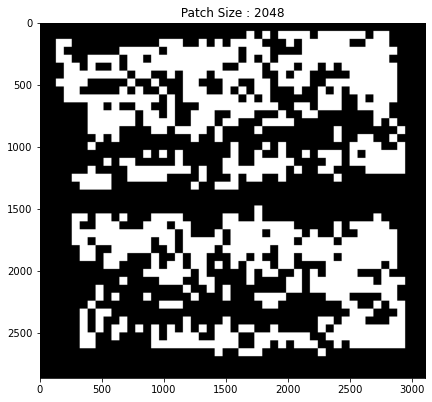

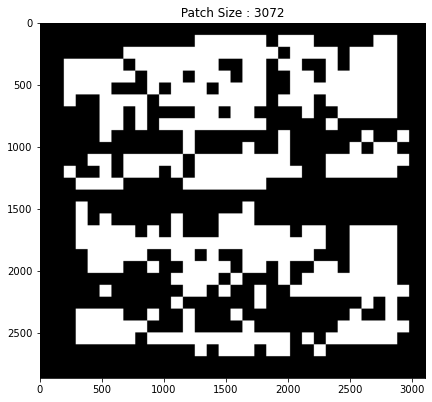

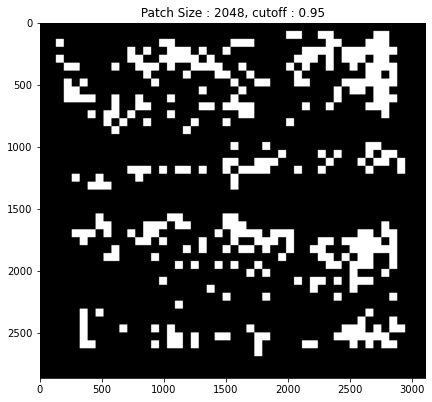

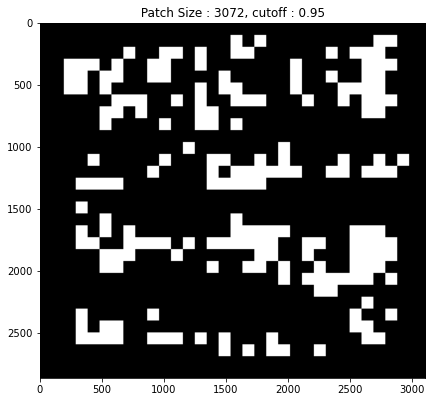



Patient Name : S14-23323-3Q-HIGH


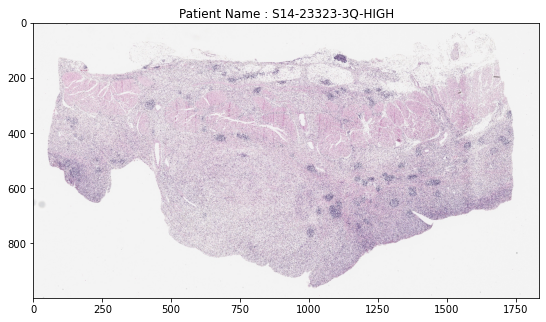

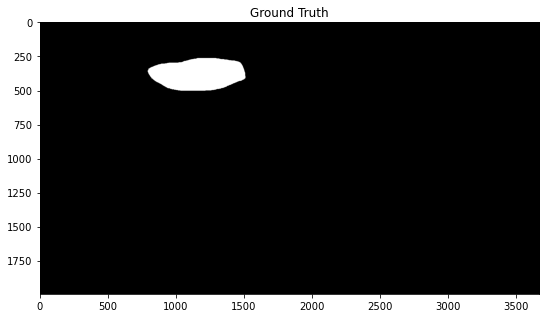

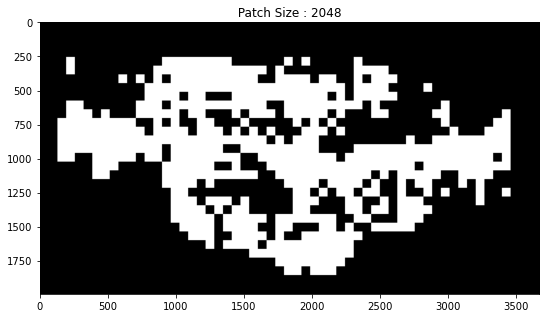

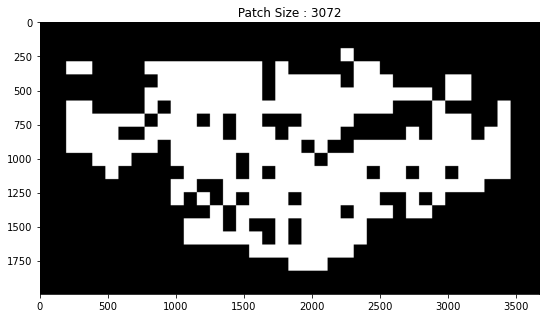

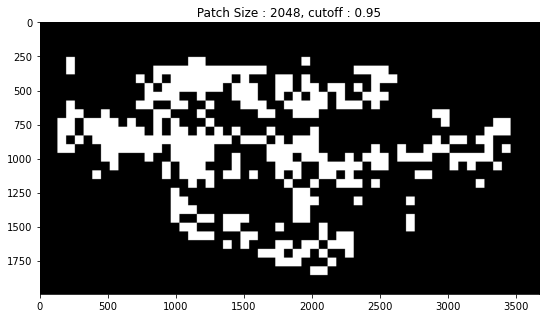

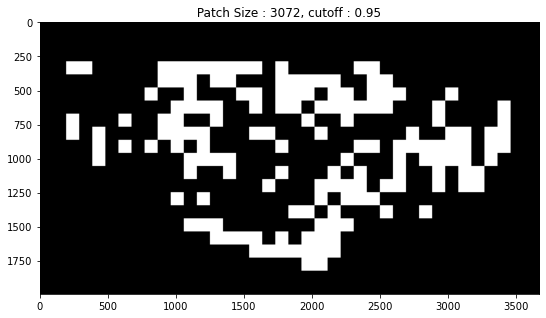



Patient Name : S14-10290-3S-INT


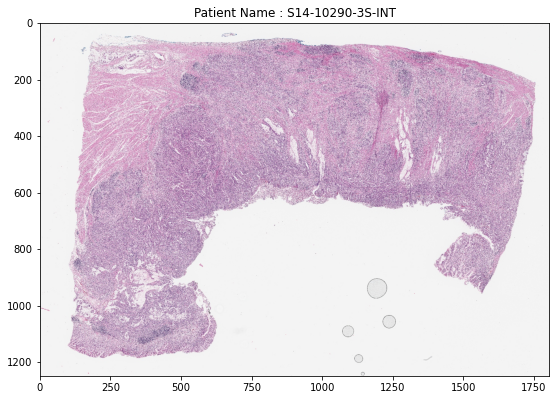

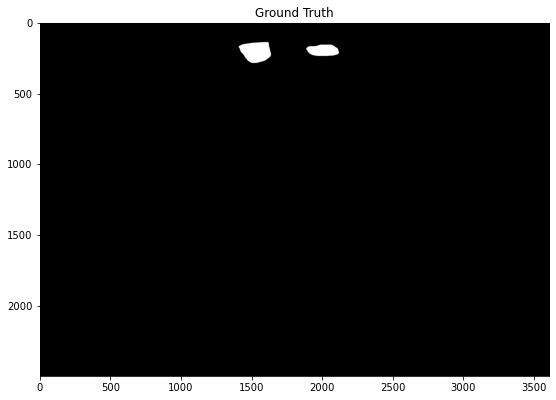

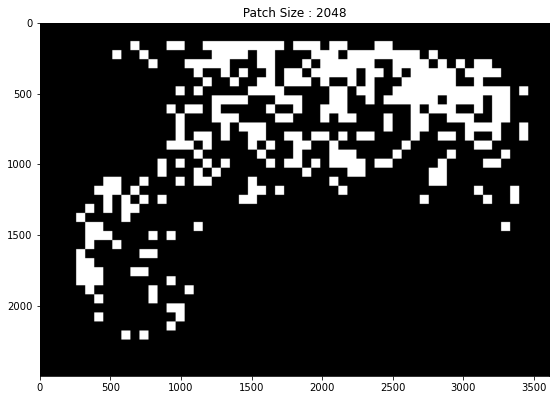

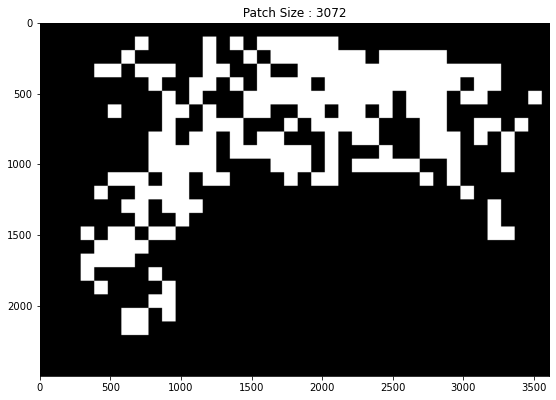

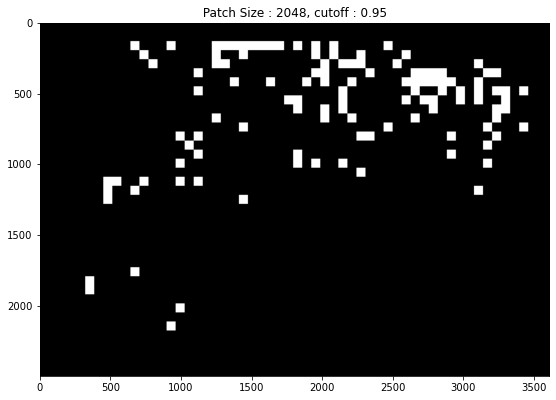

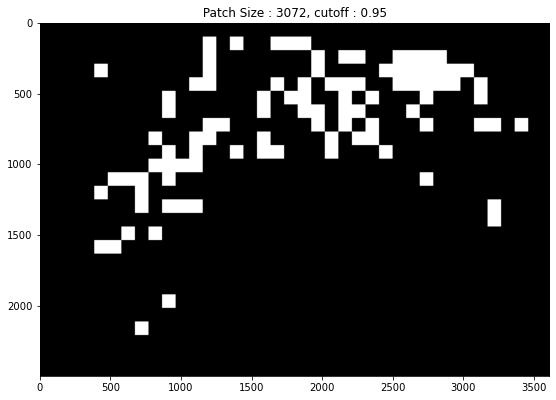



Patient Name : S14-22616-3Q-int


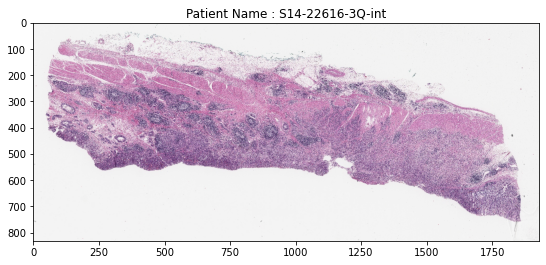

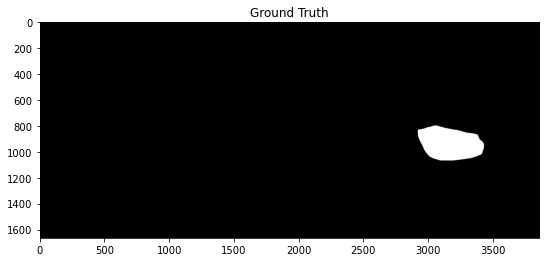

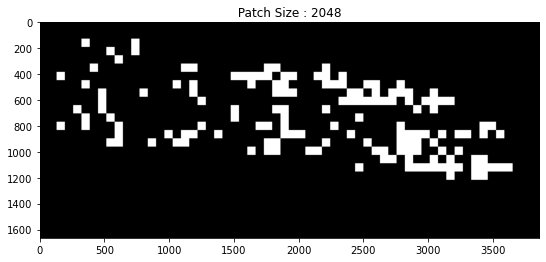

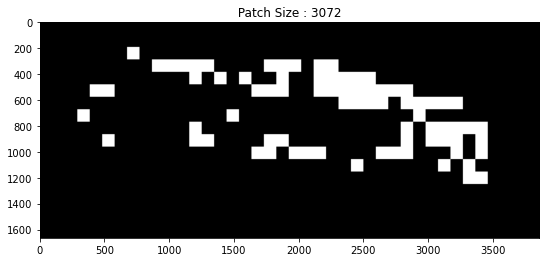

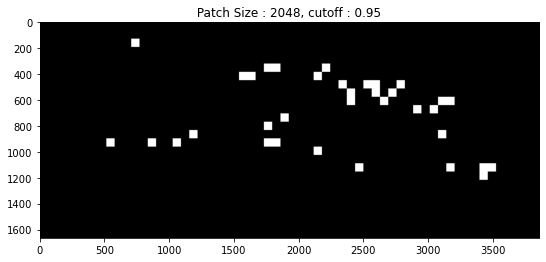

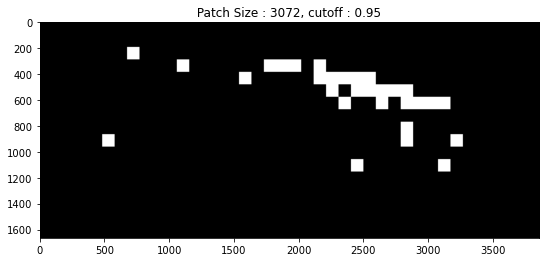



Patient Name : S15-28817-8Z-low


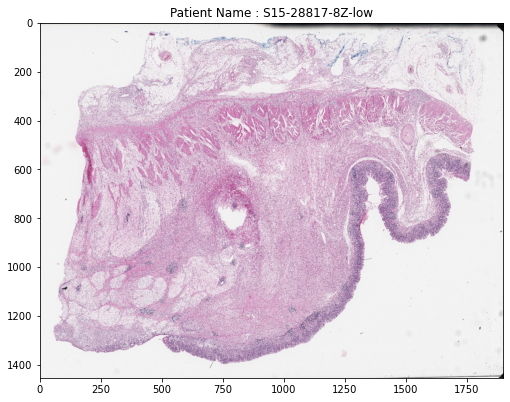

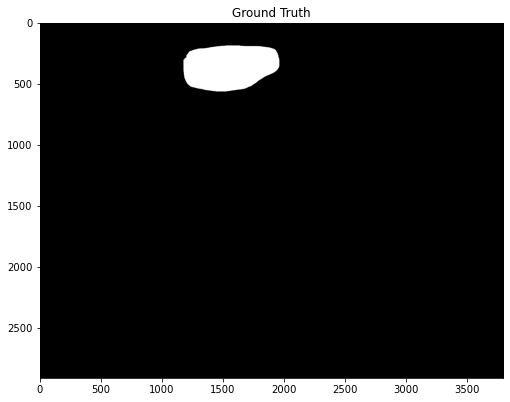

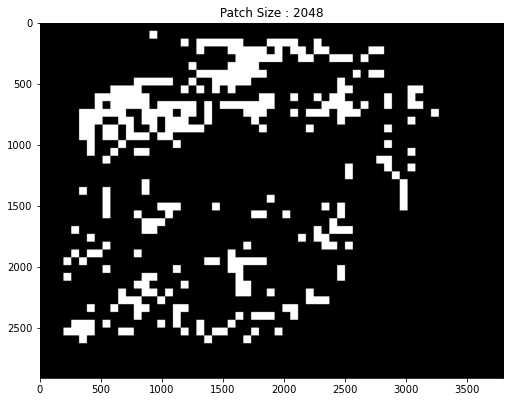

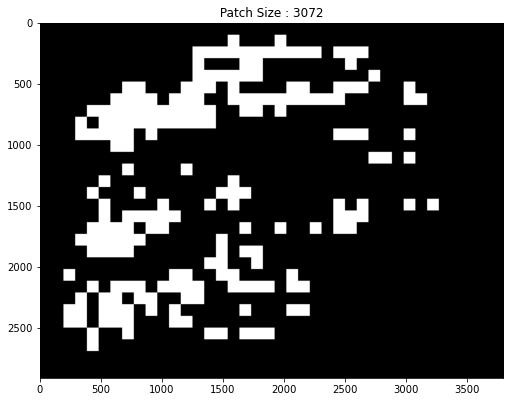

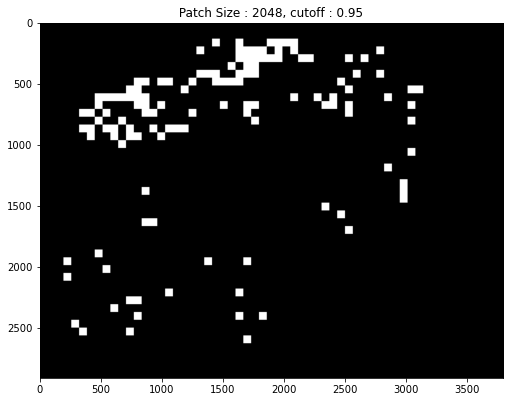

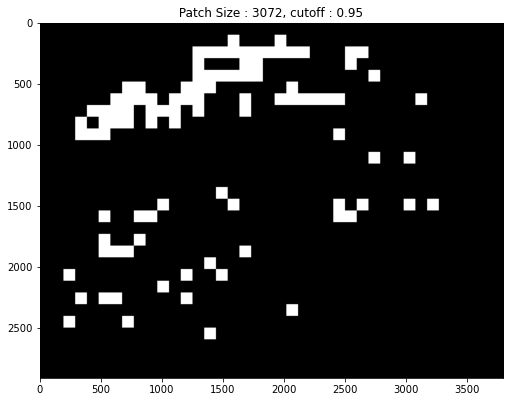



Patient Name : S14-06803-MG1-HIGH


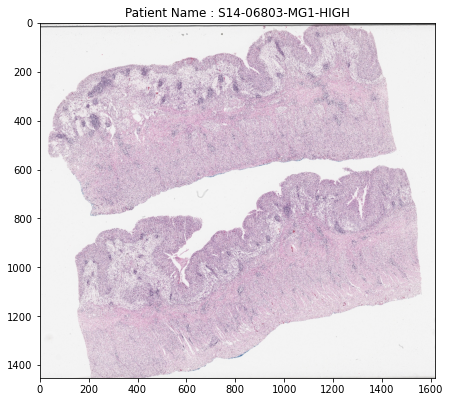

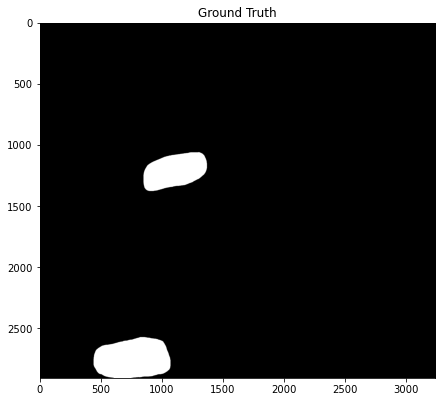

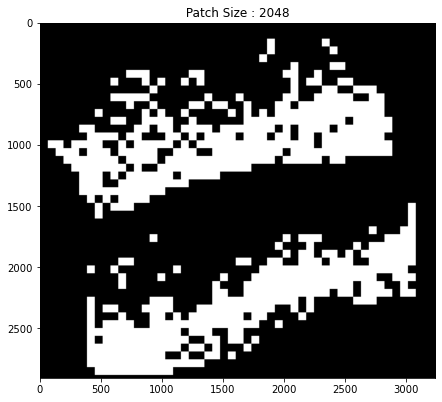

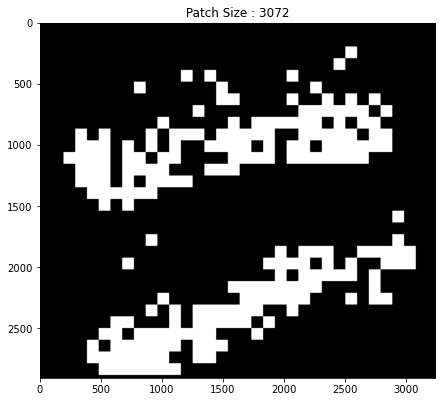

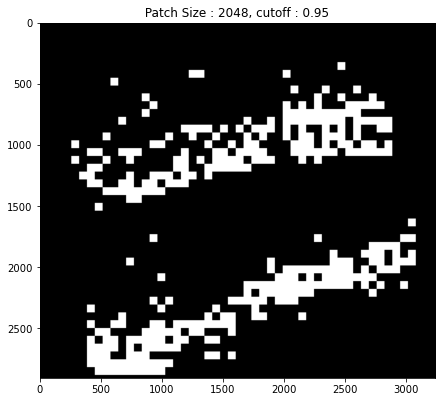

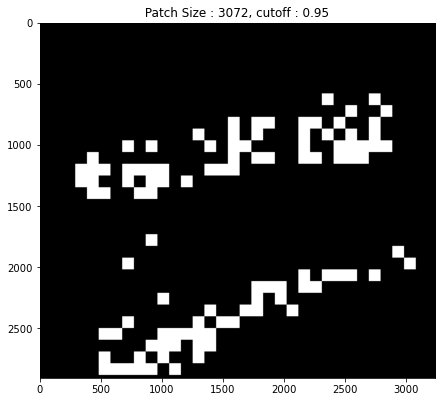



Patient Name : S15-20879-3N-high


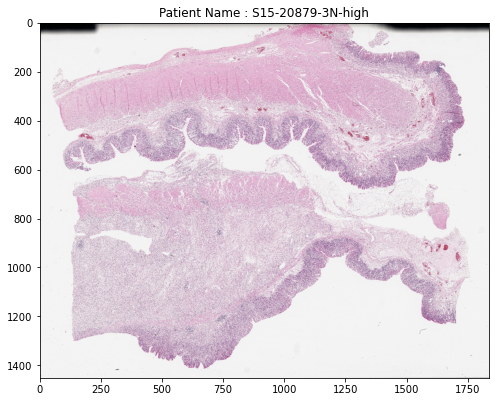

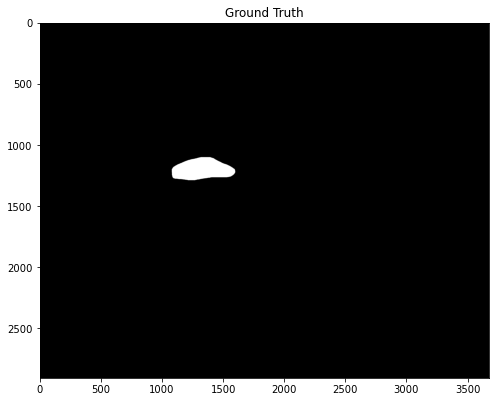

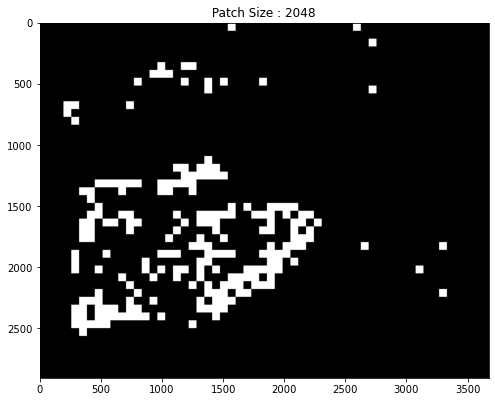

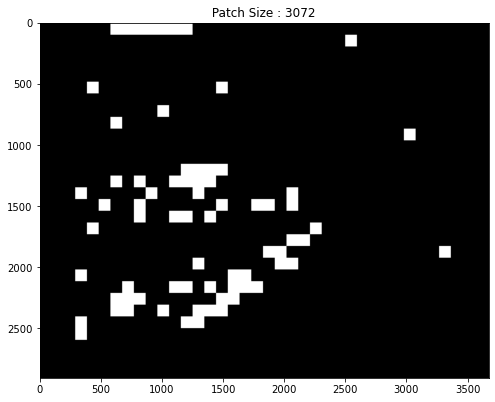

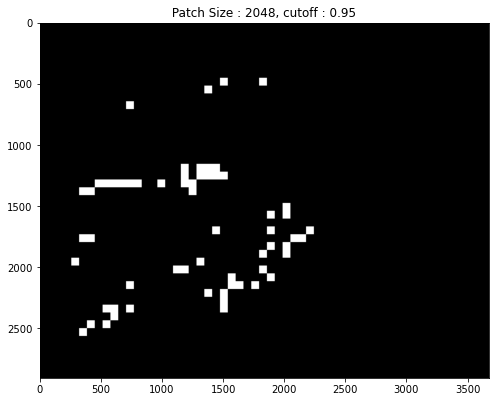

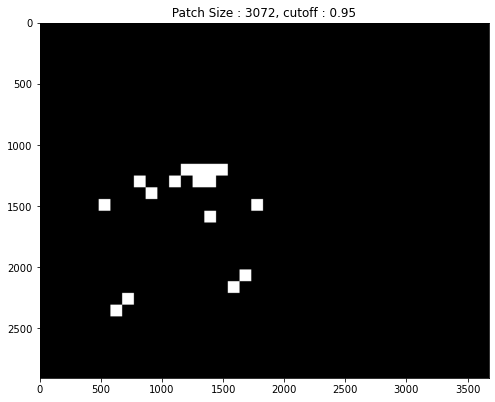



Patient Name : S14-29271-3U-high


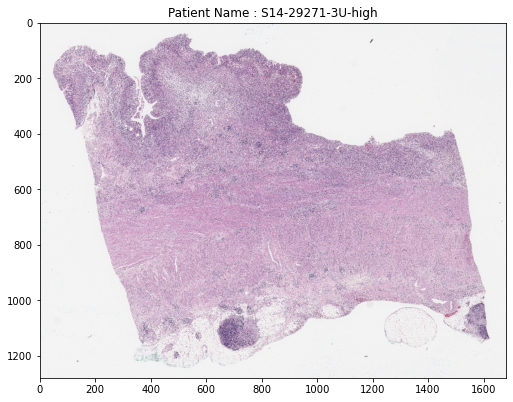

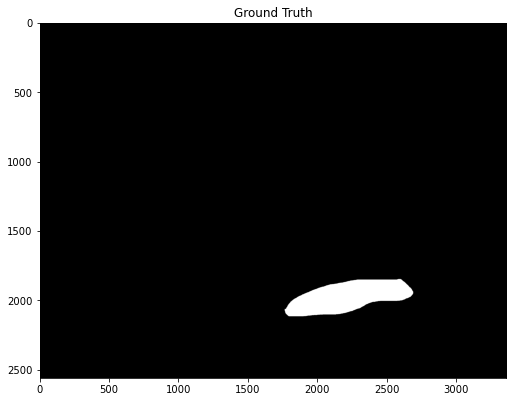

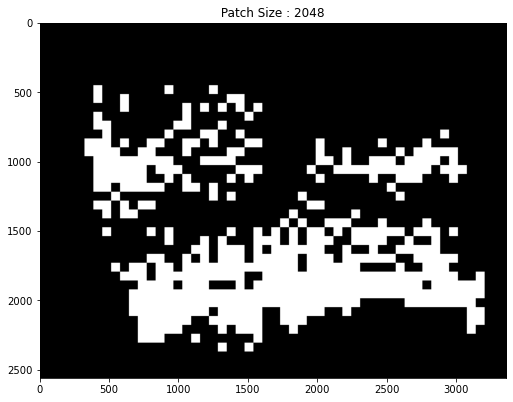

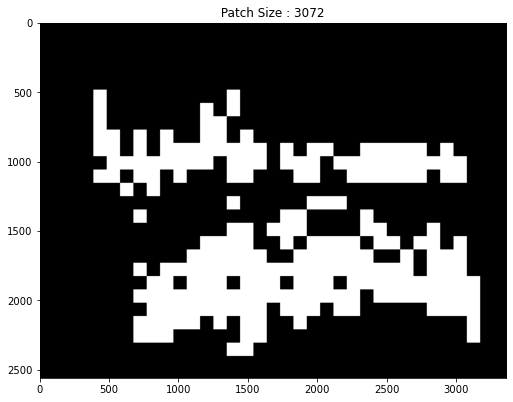

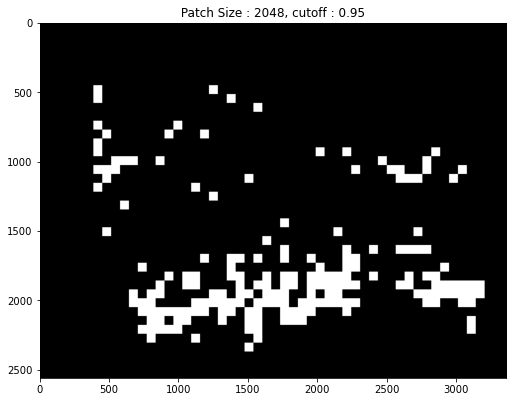

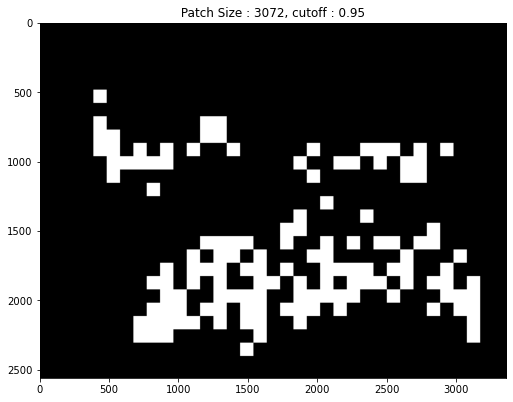



Patient Name : S15-16071-3O-high


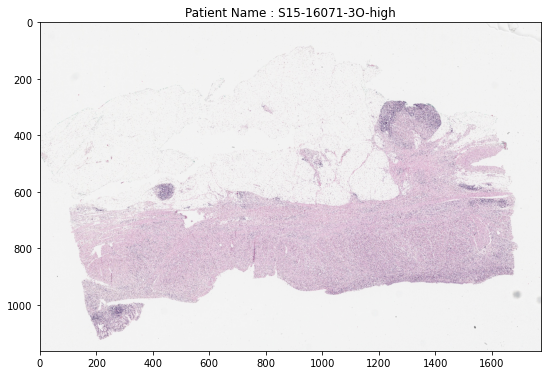

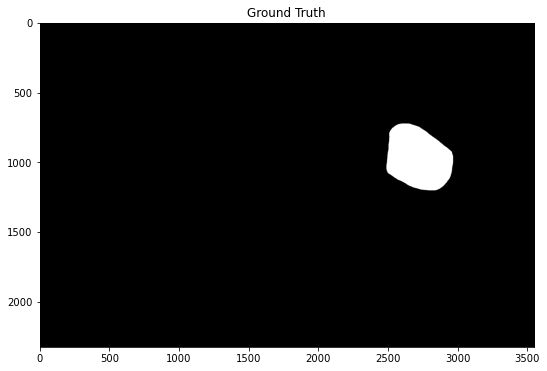

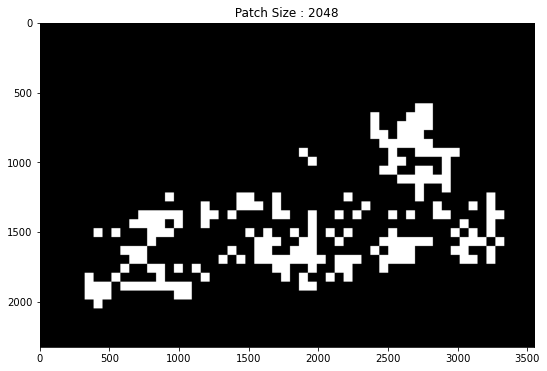

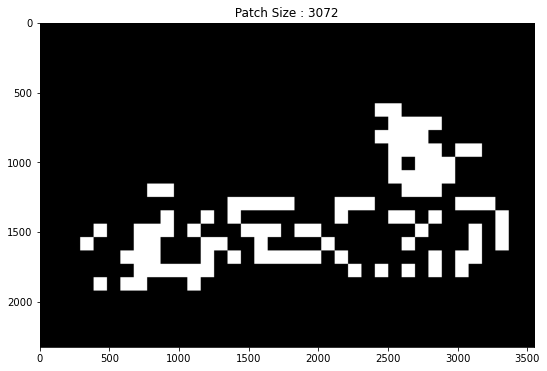

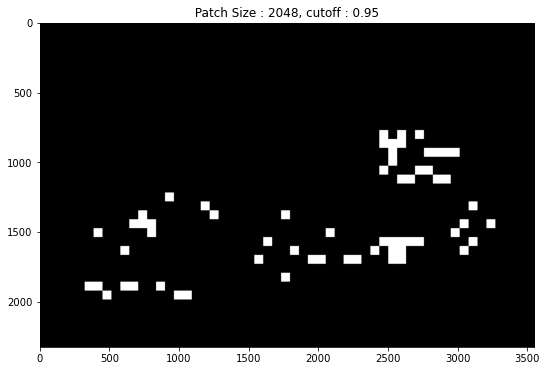

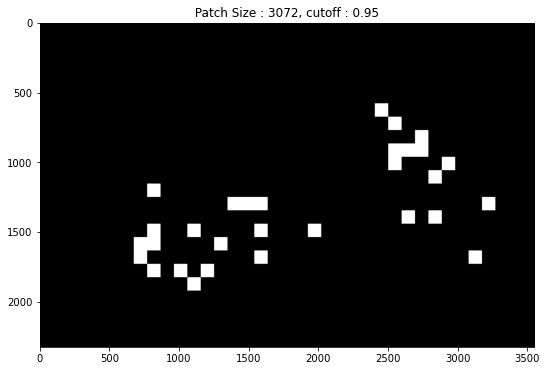



Patient Name : S14-42815-3P-high


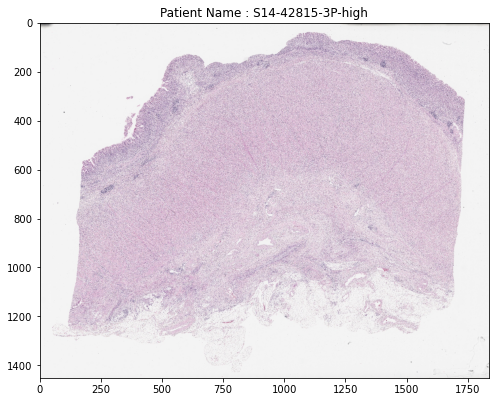

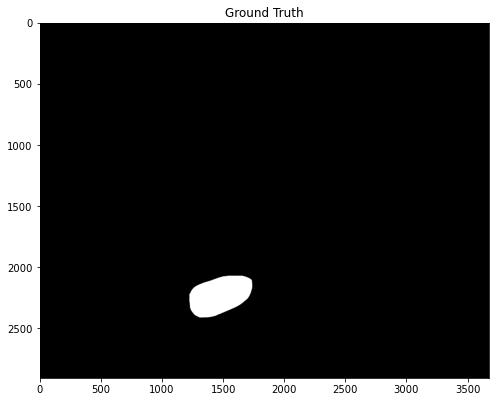

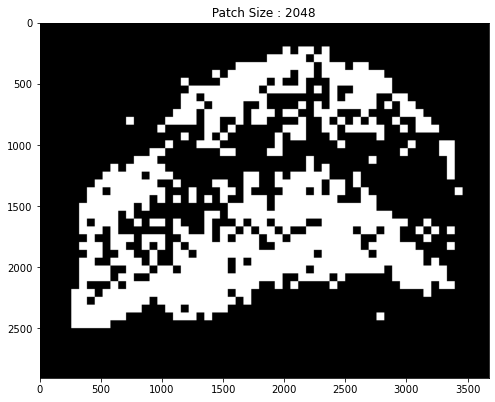

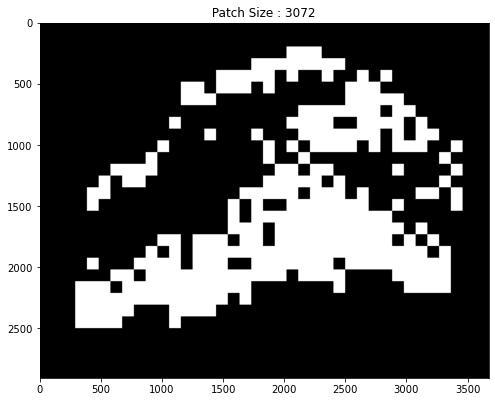

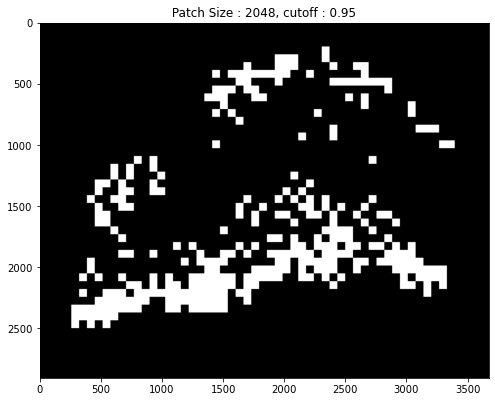

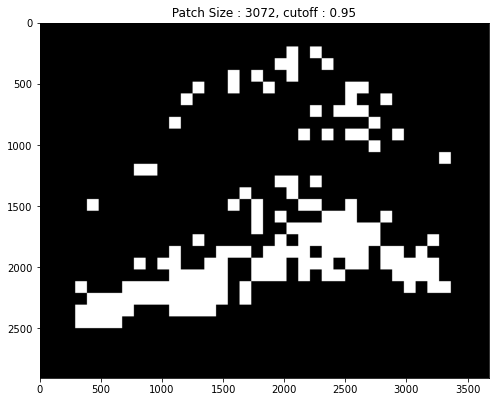

In [63]:
for i in range(len(patient_name)):
    
    
    try:
    
        patient = patient_name[i]

        print("Patient Name : {}".format(patient))

        idx = [i.split('/')[-1].split('.')[0] == patient for i in image_path]
        image = np.array(image_path)[idx][0]       
        image = cv2.imread(image)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        plt.imshow(image, cmap='gray')
        plt.title("Patient Name : {}".format(patient))
        plt.tight_layout(-5)
        plt.show()


        idx = [i.split('/')[-1].split('.')[0] == patient for i in binary_path]
        GT_path = np.array(binary_path)[idx][0]

        GT = np.load(GT_path)
        plt.imshow(GT, cmap='gray')
        plt.title("Ground Truth")
        plt.tight_layout(-5)
        plt.show()



        idx = [i.split('/')[-1].split('.')[0] == patient for i in path_2048]
        path_2048_temp = np.array(path_2048)[idx][0]    

        idx = [i.split('/')[-1].split('.')[0] == patient for i in path_3072]
        path_3072_temp = np.array(path_3072)[idx][0]      


        cutoff = 0.95
        
        result2048 = np.load(path_2048_temp)
        cut2048 = np.argmax(result2048>cutoff, axis=2)
        result2048 = np.argmax(result2048, axis=2)

        result3072 = np.load(path_3072_temp)
        cut3072 = np.argmax(result3072>cutoff, axis=2)
        result3072 = np.argmax(result3072, axis=2)

        plt.imshow(result2048, cmap='gray')
        plt.title(" Patch Size : 2048 ")
        plt.tight_layout(-5)
        plt.show()

        plt.imshow(result3072, cmap='gray')
        plt.title(" Patch Size : 3072 ")
        plt.tight_layout(-5)
        plt.show()
        
        
        
        plt.imshow(cut2048, cmap='gray')
        plt.title(" Patch Size : 2048, cutoff : {} ".format(cutoff))
        plt.tight_layout(-5)
        plt.show()

        plt.imshow(cut3072, cmap='gray')
        plt.title(" Patch Size : 3072, cutoff : {} ".format(cutoff))
        plt.tight_layout(-5)
        plt.show()        
        

        print("\n")
        
    except:
        pass

In [ ]:
.

In [194]:
from xml.etree.ElementTree import parse
import numpy as np
#from Class_ID_Name import *
import os
import openslide

from PIL import Image

import glob

import cv2 as cv2

import torch
import torchvision
from torchvision import transforms

from torch.utils.data import Dataset, DataLoader

from shapely.geometry import Polygon
from skimage import draw

import matplotlib.pyplot as plt

import pickle

import argparse

import warnings

import logging

warnings.filterwarnings('ignore')




parser = argparse.ArgumentParser(description="Deep Multi-Patch Hierarchical Network")
parser.add_argument("-n","--num",type = int, default = 1)
parser.add_argument("-p","--patch_size",type = int, default = 1024)
args = parser.parse_args()

num = args.num
patch_size = args.patch_size



class Annotation():
    def __init__(self):
        self.Class=[]
        self.Name = []
        self.Type = []
        self.Color = []
        self.Group = []
        self.x_s=[]
        self.y_s=[]
        self.points=[]
        self.min_x=[]
        self.max_x=[]
        self.min_y=[]
        self.max_y=[]


def xml_aperio_name_class(annot_path, annot_c):

    tree = parse(annot_path)
    root = tree.getroot()
    Annotations = root.findall('Annotation')

    if os.path.basename(annot_path)[0:2] == 'No':
        Class_Name = 'Metastasis_No'
    else:
        Class_Name = 'Metastasis_Yes'

    for Annotation in Annotations:
        regionlist = Annotation.find('Regions').findall('Region')

        # Cancer_type = Annotation.attrib['Name']
        # Cancer_type = Annotation.find('Attributes').find('Attribute').attrib['Name']
        # assert Cancer_type in CLASS_ID_NAME_Samsung.keys()
        for region in regionlist:
            vertices = region.find('Vertices').findall('Vertex')
            region_X = []
            region_Y = []
            region_Points = []
            if len(vertices) > 0:
                for vertex in vertices:
                    x = int(round(float(vertex.attrib['X']) ))
                    y = int(round(float(vertex.attrib['Y']) ))
                    region_X.append(x)
                    region_Y.append(y)
                    region_Points.append([x, y])

                annot_c.x_s.append(region_X)
                annot_c.y_s.append(region_Y)

                annot_c.min_x.append(min(region_X))
                annot_c.max_x.append(max(region_X))
                annot_c.min_y.append(min(region_Y))
                annot_c.max_y.append(max(region_Y))

                annot_c.points.append(region_Points)
                annot_c.Class.append(Class_Name)

    return annot_c




def xml_aperio_multi_class(annot_path):

    tree = parse(annot_path)
    root = tree.getroot()
    Annotations = root.findall('Annotation')
    Annotation_X = []
    Annotation_Y = []
    class_ids=[]
    temp_vertex_count = 0
    for Annotation in Annotations:
        regionlist = Annotation.find('Regions').findall('Region')
        Cancer_type = Annotation.attrib['Name']
        # Cancer_type = Annotation.find('Attributes').find('Attribute').attrib['Name']
        assert Cancer_type in CLASS_ID_NAME_Samsung.keys()
        for region in regionlist:
            vertices = region.find('Vertices').findall('Vertex')
            region_X = []
            region_Y = []
            if len(vertices) > 0:
                for vertex in vertices:
                    x = int(round(float(vertex.attrib['X']) ))
                    y = int(round(float(vertex.attrib['Y']) ))
                    region_X.append(x)
                    region_Y.append(y)
                Annotation_X.append(region_X)
                Annotation_Y.append(region_Y)
                class_ids.append(CLASS_ID_NAME_Samsung[Cancer_type])

    return Annotation_X, Annotation_Y, class_ids



def xml_aperio_single_class(annot_path,seg_name):

    assert seg_name in CLASS_ID_NAME_CNN3.keys()
    tree = parse(annot_path)
    root = tree.getroot()
    Annotations = root.findall('Annotation')
    Annotation_X = []
    Annotation_Y = []
    class_ids=[]
    temp_vertex_count = 0
    for Annotation in Annotations:
        regionlist = Annotation.find('Regions').findall('Region')

        for region in regionlist:
            vertices = region.find('Vertices').findall('Vertex')
            region_X = []
            region_Y = []
            if len(vertices) > 0:
                for vertex in vertices:
                    x = int(round(float(vertex.attrib['X']) ))
                    y = int(round(float(vertex.attrib['Y']) ))
                    region_X.append(x)
                    region_Y.append(y)
                Annotation_X.append(region_X)
                Annotation_Y.append(region_Y)
                class_ids.append(CLASS_ID_NAME_CNN3[seg_name])

    return Annotation_X, Annotation_Y, class_ids


def Parse_Qupath_Annotation(annotation_fn,annot_c):

    def Points_Split(temp_points_str):
        temp_points_str = temp_points_str.replace('[','')
        temp_points_str = temp_points_str.replace(']','')
        temp_points_str = temp_points_str.split('Point:')[1:]
        return temp_points_str

    lines = [line.rstrip('\n') for line in open(annotation_fn)]
    img_path = lines[0]
    for i in range(1,len(lines),2):
        annot_c.Class.append(lines[i])
        temp_points_str = Points_Split(lines[i+1])
        temp_x_s = []
        temp_y_s = []
        temp_points = []
        for ii in range(0,len(temp_points_str)):
            temp_x = round(float(temp_points_str[ii].split(',')[0]))
            temp_y = round(float(temp_points_str[ii].split(',')[1]))
            temp_x_s.append(temp_x)
            temp_y_s.append(temp_y)
            temp_points.append([temp_x,temp_y])

        annot_c.x_s.append(temp_x_s)
        annot_c.y_s.append(temp_y_s)
        annot_c.min_x.append(min(temp_x_s))
        annot_c.max_x.append(max(temp_x_s))
        annot_c.min_y.append(min(temp_y_s))
        annot_c.max_y.append(max(temp_y_s))
        annot_c.points.append(temp_points)

    return annot_c, img_path



    return annot_c

def ACDC_S1_XML_Parsing(annot_path, annot_c):

    tree = parse(annot_path)
    root = tree.getroot()
    Annotations = root.find('Annotations').findall('Annotation')

    temp_vertex_count = 0
    for Annotation in Annotations:
        Cancer_type = Annotation.attrib['Name']
        if Cancer_type == 'Annot_ROI':
            continue
        region_X = []
        region_Y = []
        region_Points = []
        Coords = Annotation.find('Coordinates').findall('Coordinate')
        for Coord in Coords:

            x = int(round(float(Coord.attrib['X'])))
            y = int(round(float(Coord.attrib['Y'])))
            region_X.append(x)
            region_Y.append(y)
            region_Points.append([x, y])
        
        
        annot_c.x_s.append(region_X)
        annot_c.y_s.append(region_Y)
        annot_c.min_x.append(min(region_X))
        annot_c.max_x.append(max(region_X))
        annot_c.min_y.append(min(region_Y))
        annot_c.max_y.append(max(region_Y))
        annot_c.points.append(region_Points)

        annot_c.Class.append('Cancer') ##CLASS_ID_NAME_ACDC_S1

    return annot_c


def ACDC_S1_XML_Parsing_Tiling(annot_path, annot_c):

    tree = parse(annot_path)
    root = tree.getroot()
    Annotations = root.find('Annotations').findall('Annotation')

    temp_vertex_count = 0
    for Annotation in Annotations:
        Name = Annotation.attrib['Name']
        Type = Annotation.attrib['Type']
        Color = Annotation.attrib['Color']
        Group = Annotation.attrib['PartOfGroup']

        region_X = []
        region_Y = []
        region_Points = []
        Coords = Annotation.find('Coordinates').findall('Coordinate')
        for Coord in Coords:

            x = int(round(float(Coord.attrib['X'])))
            y = int(round(float(Coord.attrib['Y'])))
            region_X.append(x)
            region_Y.append(y)
            region_Points.append([x, y])
        
        
        annot_c.Name.append(Name)
        annot_c.Type.append(Type)
        annot_c.Color.append(Color)
        annot_c.Group.append(Group)
        
        annot_c.x_s.append(region_X)
        annot_c.y_s.append(region_Y)
        annot_c.min_x.append(min(region_X))
        annot_c.max_x.append(max(region_X))
        annot_c.min_y.append(min(region_Y))
        annot_c.max_y.append(max(region_Y))
        annot_c.points.append(region_Points)

        if Name == 'Annot_ROI':
            annot_c.Class.append(CLASS_ID_NAME_ACDC_S1_Tiling['Annot_ROI'])
        else:
            annot_c.Class.append(CLASS_ID_NAME_ACDC_S1_Tiling['Cancer'])
            
    return annot_c

usage: ipykernel_launcher.py [-h] [-n NUM] [-p PATCH_SIZE]
ipykernel_launcher.py: error: unrecognized arguments: -f /Arontier/People/hnefa335/.local/share/jupyter/runtime/kernel-15ab038d-1ab4-4e8b-8a1d-7b89f946cffa.json


SystemExit: 2